In [1]:
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported

from datasets import Dataset
from vllm import SamplingParams
from transformers import TrainingArguments, TrainerCallback
from trl import SFTTrainer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-27 14:07:54 __init__.py:190] Automatically detected platform cuda.


In [2]:
import random
import json
import re
import itertools    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sampling.sampling_fallacies_detection import load_all_dataset, sample_data, get_prompt_train_sample, get_prompt_test_val

In [3]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
paths = {
    'cocolofa': './Data_jsonl/cocolofa.jsonl',
    'mafalda': './Data_jsonl/mafalda.jsonl'
}

In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name= "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    fast_inference=True,
    gpu_memory_utilization=0.8
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.50.0. vLLM: 0.7.2.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.451 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit with actual GPU utilization = 39.8%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 44.45 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 224.
Unsloth: vLLM's KV Cache can use up to 11.36 GB. Also swap space = 6 GB.
INFO 03-27 14:08:26 config.py:542] This model supports multiple tasks: {'classify', 'embed', 'generate', 'score', 'reward'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes confi

[W327 14:08:28.906097537 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-27 14:08:28 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-27 14:08:29 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-27 14:08:38 model_runner.py:1115] Loading model weights took 5.5976 GB
INFO 03-27 14:08:38 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-27 14:08:42 worker.py:267] Memory profiling takes 3.32 seconds
INFO 03-27 14:08:42 worker.py:267] the current vLLM instance can use total_gpu_memory (44.45GiB) x gpu_memory_utilization (0.40) = 17.69GiB
INFO 03-27 14:08:42 worker.py:267] model weights take 5.60GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.05GiB; the rest of the memory reserved for KV Cache is 10.98GiB.
INFO 03-27 14:08:42 executor_base.py:110] # CUDA blocks: 5623, # CPU blocks: 3072
INFO 03-27 14:08:42 executor_base.py:115] Maximum concurrency for 2048 tokens per request: 43.93x
INFO 03-27 14:08:48 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 31/31 [01:03<00:00,  2.05s/it]

INFO 03-27 14:09:52 model_runner.py:1562] Graph capturing finished in 64 secs, took 0.75 GiB
INFO 03-27 14:09:52 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 73.54 seconds



Unsloth 2025.3.18 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [6]:
SYSTEM_PROMPT = 'You are an expert in argumentation. Your task is to determine the type of fallacy in the given [SENTENCE]. The fallacy would be in the [FALLACY] Set. Utilize the [TITLE] and the [FULL TEXT] as context to support your decision.\nYour answer must be in the following format with only the fallacy in the answer section:\n<|ANSWER|><answer><|ANSWER|>.'

n_sample = 300
data = load_all_dataset(paths)
t = data.get('cocolofa').get('train')
sampled_data_train, fallacies, stat_sample = sample_data(data, n_sample)
prt_val, prt_test = get_prompt_test_val(data, fallacies, SYSTEM_PROMPT)
cpt = 0
for k,v in sampled_data_train.items():
    for i in v:
        cpt += 1
print(f'lenght sampled data: {cpt}')
prt_train = get_prompt_train_sample(
    data=sampled_data_train,
    labels=fallacies,
    system_prompt=SYSTEM_PROMPT
)
df_train = pd.DataFrame().from_records(prt_train)
df_val = pd.DataFrame().from_records(prt_val)
df_test = pd.DataFrame().from_records(prt_test)
df_tmp = df_train.sample(32)
df_tmp_val = df_val.sample(10)
df_tmp_test = df_test.sample(10)
print(len(df_val['answer'].value_counts().index.to_list()))
print(len(df_test['answer'].value_counts().index.to_list()))
print(len(df_train['answer'].value_counts().index.to_list()))

lenght sampled data: 300
20
20
20


In [ ]:
def formatting_prompt(ex):
    text = tokenizer.apply_chat_template(ex.get('prompt'),tokenize = False, add_generation_prompt = False)
    return { 'text': text, }

SAMPLING_PARAMS = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 128,
)
data_train = Dataset.from_pandas(df_train).map(formatting_prompt, batched=True)
data_val = Dataset.from_pandas(df_val).map(formatting_prompt, batched=True)
data_test = Dataset.from_pandas(df_test).map(formatting_prompt, batched=True)
tmp_dataset = Dataset.from_pandas(df_tmp).map(
    formatting_prompt,
    batched=True
)
tmp_dataset_val = Dataset.from_pandas(df_tmp_val).map(
    formatting_prompt,
    batched=True
)
tmp_dataset_test = Dataset.from_pandas(df_tmp_test).map(
    formatting_prompt,
    batched=True
)

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1744 [00:00<?, ? examples/s]

Map:   0%|          | 0/1761 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

["<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are an expert in argumentation. Your task is to determine the type of fallacy in the given [SENTENCE]. The fallacy would be in the [FALLACY] Set. Utilize the [TITLE] and the [FULL TEXT] as context to support your decision.\nYour answer must be in the following format with only the fallacy in the answer section:\n<|ANSWER|><answer><|ANSWER|>.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n[FALLACY]: {'appeal to majority', 'guilt by association', 'ad populum', 'false analogy', 'appeal to worse problems', 'appeal to fear', 'false causality', 'causal oversimplification', 'circular reasoning', 'straw man', 'appeal to authority', 'equivocation', 'false dilemma', 'appeal to nature', 'appeal to tradition', 'slippery slope', 'appeal to ridicule', 'hasty generalization', 'ad hominem', 'none'}\n[TITLE]: Pacific groups celebrate Ocean Week by opposing deep se

In [24]:
def gen(txt, model, sampling_params):
    output = model.fast_generate(
        txt,
        sampling_params = sampling_params,
    )[0].outputs[0].text
    
    return output

def format_output(answer: str, fallacies: set) -> list:
    s = '<[|]ANSWER[|]>'
    tmp = re.split(s, answer)
    pred= [i for i in tmp if i in fallacies]
    return pred

def zero_shot_gen(data: list[str], model, fallacies: set, sampling_params) -> list:
    res = []
    for i in data:
        out = gen(i, model, sampling_params)
        pred = format_output(out, fallacies)
        res.append(pred)
    return res

In [35]:
class custom_validation_callback(TrainerCallback):
    def __init__(self, data, sampling_params, fallacies, n_step=10):
        super().__init__()
        self.val_dataset = data
        self.sampling_params = sampling_params
        self.fallacies = fallacies
        self.n_step=n_step
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.n_step == 0 and state.global_step > 0 :
            model.save_lora('sft_save_lora')
            FastLanguageModel.for_inference(model)
            pred = zero_shot_gen(
                data=self.val_dataset['text'],
                model=model,
                fallacies=self.fallacies,
                sampling_params=self.sampling_params
            )
            tmp_pred = [i if i != [] else ['Failed'] for i in pred]
            d = pd.DataFrame().from_records(tmp_pred)
            d['truth_label'] = self.val_dataset['answer']
            try:
                d.to_csv(
                    './validation_res.csv',
                    index=False,
                    mode='a',
                    header=['pred', 'truth_label']
                )
            except FileNotFoundError:
                d.to_csv('./validation_res.csv', index=False, header=['pred', 'truth_label'])
        return super().on_step_end(args, state, control, **kwargs)

class custom_test_callback(TrainerCallback):
    def __init__(self, data, sampling_params, fallacies):
        super().__init__()
        self.test_dataset = data
        self.sampling_params = sampling_params
        self.fallacies = fallacies
    def on_train_end(self, args, state, control, **kwargs):
        model.save_lora('sft_save_lora')
        FastLanguageModel.for_inference(model)
        pred = zero_shot_gen(
            data=self.test_dataset['text'],
            model=model,
            fallacies=self.fallacies,
            sampling_params=self.sampling_params
        )
        tmp_pred = [i if i != [] else ['Failed'] for i in pred]
        d = pd.DataFrame().from_records(tmp_pred)
        d['truth_label'] = self.test_dataset['answer']
        try:
            d.to_csv('./test_res.csv', index=False, mode='a', header=['pred','truth_label'])
        except FileNotFoundError:
            d.to_csv('./test_res.csv', index=False, header=['pred', 'truth_label'])
        return super().on_train_end(args, state, control, **kwargs)

In [37]:
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 5,
    num_train_epochs = 1, # Set this for 1 full training run.
    # max_steps = 60,
    learning_rate = 2e-4,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = "./outputs",
    report_to = "tensorboard", # Use this for WandB etc
)   
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tmp_dataset,
    # formatting_func=formatting_prompt,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args,
    callbacks= [
        custom_validation_callback(
            data=tmp_dataset_val,
            sampling_params=SAMPLING_PARAMS,
            fallacies=fallacies,
            n_step=2
        ),
        custom_test_callback(
            data=tmp_dataset_test,
            sampling_params=SAMPLING_PARAMS,
            fallacies=fallacies
        )
    ]
)
trainer.train()

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/32 [00:00<?, ? examples/s]

8692.15s - thread._ident is None in _get_related_thread!
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 32 | Num Epochs = 1 | Total steps = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.905100


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 107.98 toks/s, output: 31.27 toks/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 448.00 MiB. GPU 0 has a total capacity of 44.45 GiB of which 127.06 MiB is free. Process 1567766 has 22.01 GiB memory in use. Including non-PyTorch memory, this process has 22.27 GiB memory in use. Of the allocated memory 21.32 GiB is allocated by PyTorch, with 166.00 MiB allocated in private pools (e.g., CUDA Graphs), and 66.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:
def get_precision_recall(data):
    try:
        tmp = data.apply(lambda x: x['pred'] == x['lbl'], axis=1)
        tp = tmp.value_counts().loc[True]
        score = tp / len(tmp)
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn
    except (KeyError, ZeroDivisionError):
        tp = 0
        score = 0
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn

def get_f1(precision, recall):
    try:
        f1 = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        f1 = 0
    return f1

def get_metrics(data, labels):
    tp_preci = 0
    tp_rec = 0
    fn = 0
    fp = 0
    res = {}
    for l in labels:
        df_on_pred = data[data['pred'] == l]
        df_on_label = data[data['lbl'] == l]
        precision, tp_p, fp_p = get_precision_recall(df_on_pred)
        recall, tp_r, fn_r = get_precision_recall(df_on_label)
        f1 = get_f1(precision, recall)
        res.update({l: (f1, precision, recall)})
        fn += fn_r
        fp += fp_p
        tp_preci += tp_p
        tp_rec += tp_r
    precision_all_data = tp_preci / (tp_preci + fp)
    recall_all_data = tp_rec / (tp_rec + fn)
    f1_all_data = get_f1(precision_all_data, recall_all_data)
    res.update({
        'score_all_data': (f1_all_data, precision_all_data, recall_all_data)
    })
    return res

FastLanguageModel.for_inference(model)
pred = zero_shot_gen(data_test['text'], model, fallacies, SAMPLING_PARAMS)

names_dataset = data_test['datasets']
true_labels = data_test['answer']

tmp_pred = [i if i != [] else ['Failed'] for i in pred]
pred_flat = list(itertools.chain.from_iterable(tmp_pred))

d_res = {'names': names_dataset, 'pred': pred_flat, 'lbl': true_labels}
df_res = pd.DataFrame(data=d_res)
df_res_cocolofa = df_res[df_res['names'] == 'cocolofa']
df_res_mafalda = df_res[df_res['names'] == 'mafalda']
metric = get_metrics(df_res, fallacies)
metric_cocolofa = get_metrics(df_res_cocolofa, fallacies)
metric_mafalda = get_metrics(df_res_mafalda, fallacies)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, est. speed input: 369.42 toks/s, output: 24.19 toks/s]


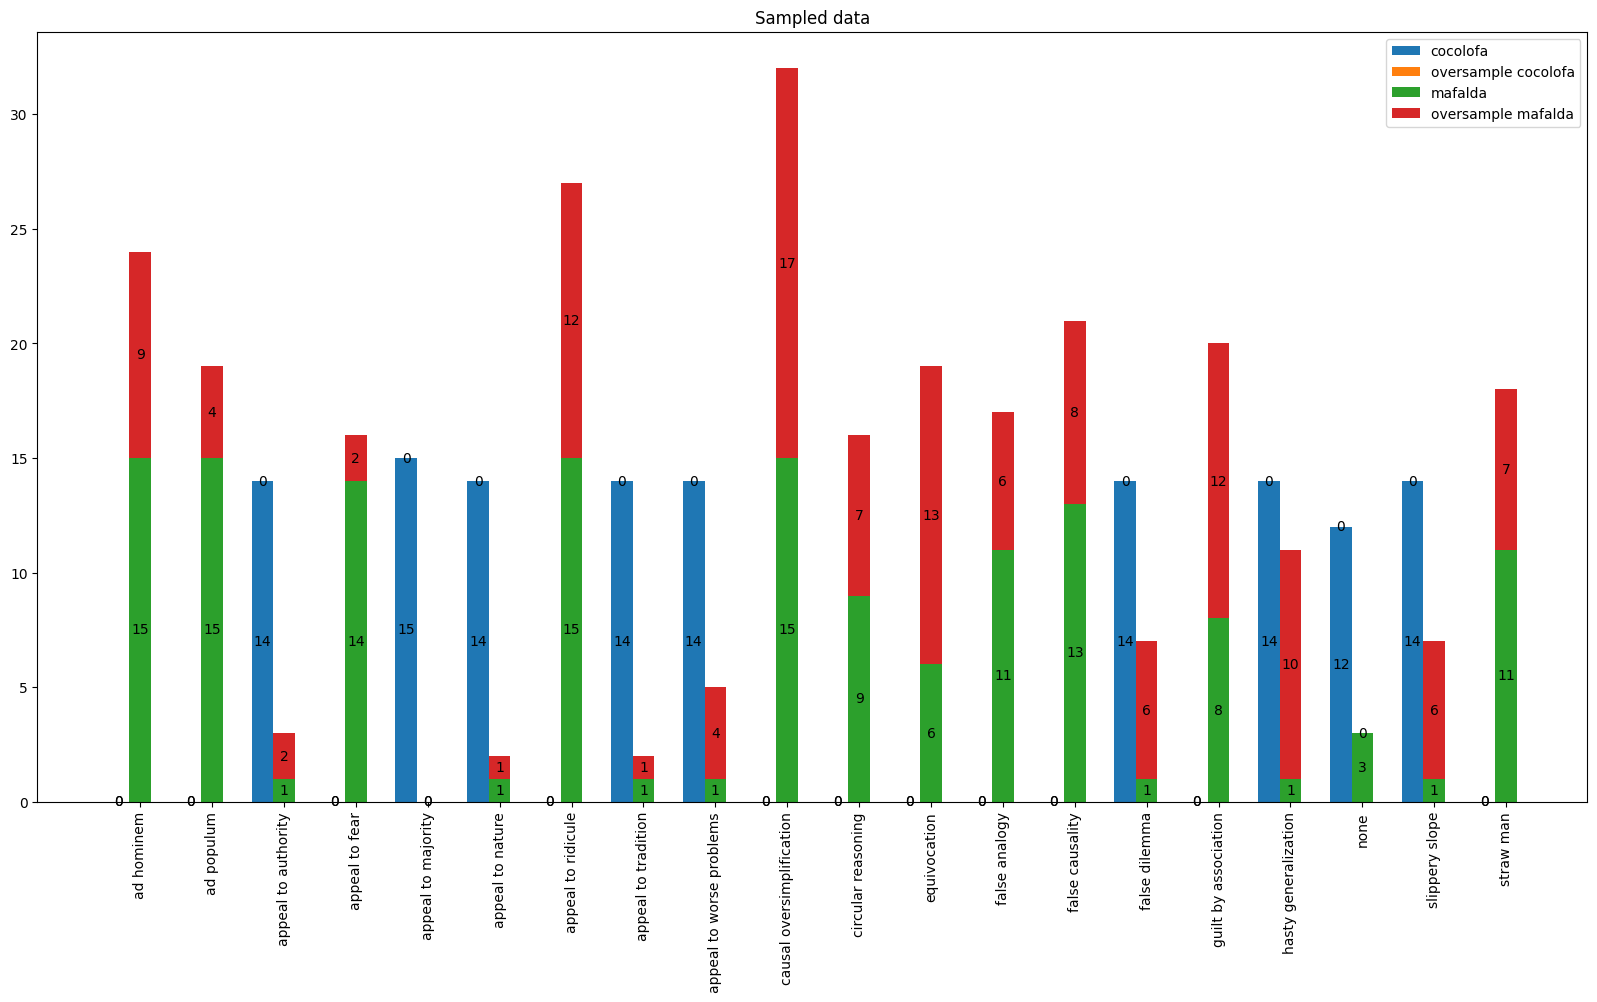

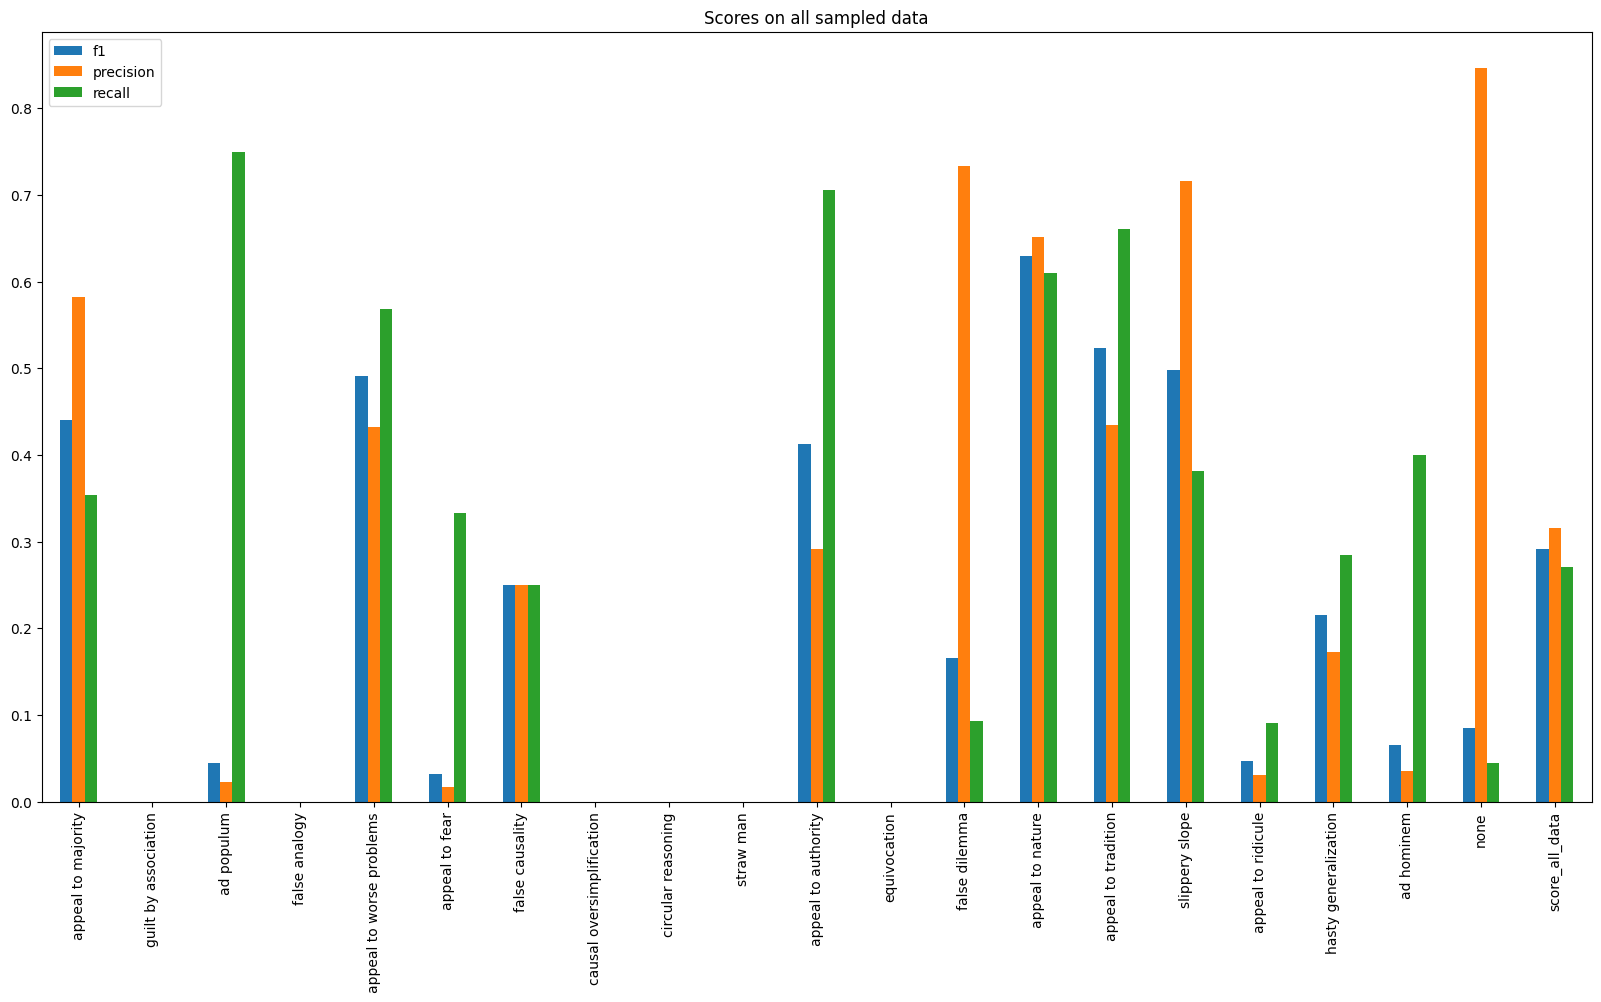

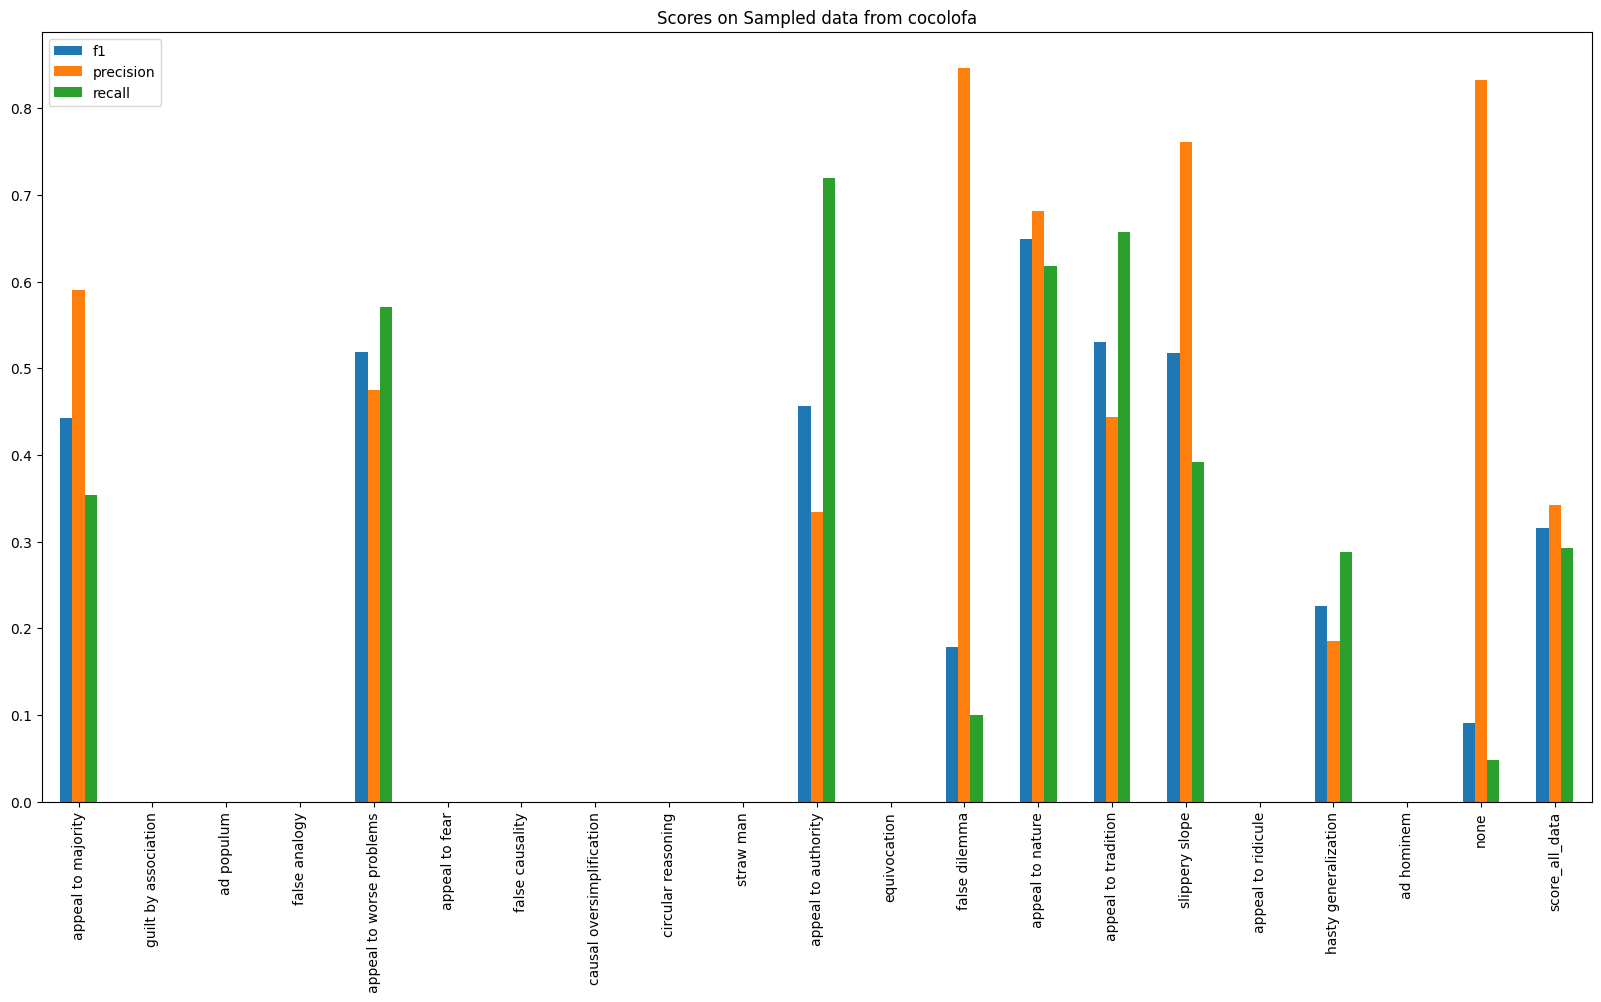

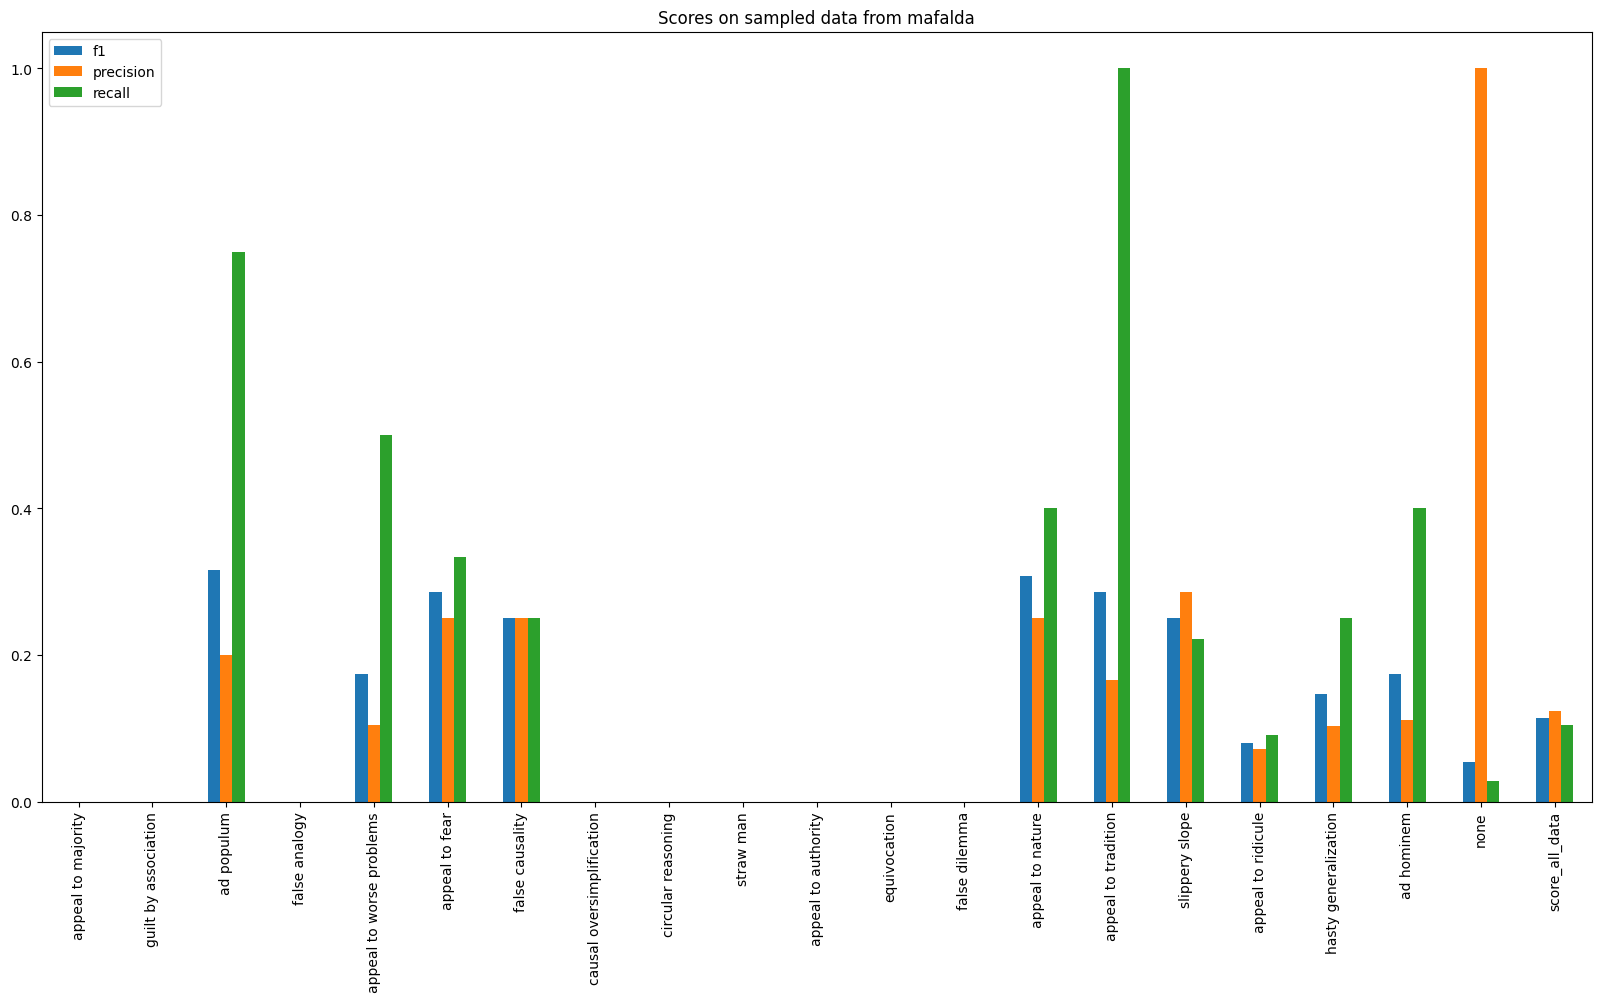

In [14]:
def plot_stat_sample(
    stat_sample: dict,
    prt_data: pd.DataFrame,
    lst_labels: set[str]
):
    width = 0.3
    nb_per_lbl = {}
    fig, ax = plt.subplots()
    d = {}
    x = np.arange(len(lst_labels))
    mult = 0
    dataset_names = prt_data['datasets'].value_counts().index.to_list()
    for name in dataset_names:
        nb_per_lbl.update({
            name: prt_data[prt_data['datasets'] == name]['answer']
            .value_counts()
        })
    df_nb_lbl = pd.DataFrame().from_dict(
        nb_per_lbl, orient='index'
    ).fillna(0).T.sort_index().astype('int32')
    df_sample_length = pd.DataFrame().from_dict(
        stat_sample.get('sample_per_label'),
        orient='index'
    ).T.sort_index()
    df_oversample_length = pd.DataFrame().from_dict(
        stat_sample.get('oversample_per_label'),
        orient='index'
    ).T.sort_index()
    for name in names_dataset:
        d.update({
            name: (
                (df_sample_length[name] - df_oversample_length[name])
                .to_list(),
                (df_nb_lbl[name] - df_sample_length[name] 
                 + df_oversample_length[name]).to_list()
            )
        })
    for k,v in d.items():
        p = ax.bar(x + width * mult, v[0], width, label=k)
        ax.bar_label(p, label_type='center')
        p = ax.bar(
            x + width * mult, v[1], width, label=f'oversample {k}', bottom=v[0]
        )
        ax.bar_label(p, label_type='center')
        mult += 1
    ax.set_xticks(x + width, sorted(lst_labels), rotation=90)
    ax.legend(loc='upper right')
    ax.set_title('Sampled data')
    fig.set_size_inches(20, 10)
    plt.show()

def plot_metric(
    metric: dict,
    columns: list[str]=['f1', 'precision', 'recall'],
    title=''
):
    # rand_mark = pd.Series(np.full((len(metric),), 1/(len(metric)-1)))
    df_metric = pd.DataFrame().from_dict(
        metric,
        orient='index',
        columns=columns
    )
    fig, ax = plt.subplots(1, 1)
    df_metric.plot(
        ax=ax,
        kind='bar',
        figsize=(20,10),
        title=title,
    )
    # rand_mark.plot(ax=ax, color='red', linestyle='dashed')
    plt.xticks(rotation=90)
    
columns = ['f1', 'precision', 'recall']
plot_stat_sample(stat_sample, df_train, fallacies)
plot_metric(metric, title='Scores on all sampled data')
plot_metric(metric_cocolofa, title='Scores on Sampled data from cocolofa')
plot_metric(metric_mafalda, title='Scores on sampled data from mafalda')